# 4.1 word2vec 개선

1. 입력층의 원핫 표현과 가중치 행렬 W_in의 matmul 연산
2. 은닉층과 가중치 행렬 W_out의 matmul과 Softmax 계층의 연산

두 연산이 병목됨.

4.1.2 Embedding 계층 구현

In [1]:
import numpy as np

W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [ ]:
idx = np.array([1, 0, 3, 0])
W[idx] # 미니배치 처리 가정

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

4.2.4 다중 분류에서 이진 분류로 (구현)

In [ ]:
import numpy as np
from layers import Embedding
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1) # broadcasting될 수 있도록
        dtarget_W = dout * h
        self.embed.backward(dtarget_W) # dtarget_W를 idx 기준으로 embed.grads에 누적
        dh = dout * target_W
        return dh

In [9]:
embed = Embedding(W)
idx = np.array([0, 3, 1])
target_W = embed.forward(idx)
h = np.arange(9).reshape(3, 3)
out = np.sum(target_W*h, axis=1)

In [20]:
print(f'W: \n{W}, idx:{idx} \n', f'target_W: \n{target_W}, \nh: \n{h}, \ntarget_W*h: \n{target_W*h}, out:{out}')

W: 
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]], idx:[0 3 1] 
 target_W: 
[[ 0  1  2]
 [ 9 10 11]
 [ 3  4  5]], 
h: 
[[0 1 2]
 [3 4 5]
 [6 7 8]], 
target_W*h: 
[[ 0  1  4]
 [27 40 55]
 [18 28 40]], out:[  5 122  86]


4.2.6 네거티브 샘플링의 샘플링 기법

In [21]:
import numpy as np

# 0에서 9까지의 숫자 중 하나를 무작위로 샘플링
np.random.choice(10)

9

In [22]:
np.random.choice(10)

0

In [23]:
# words에서 하나만 무작위로 샘플링
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'say'

In [24]:
# 5개만 무작위로 샘플링(중복 있음)
np.random.choice(words, size=5)

array(['.', 'say', '.', 'hello', 'say'], dtype='<U7')

In [25]:
# 5개만 무작위로 샘플링(중복 없음)
np.random.choice(words, size=5, replace=False)

array(['goodbye', 'I', '.', 'say', 'hello'], dtype='<U7')

In [44]:
# 확률분포에 따라 샘플링
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1] # 'you', 'say', 'goodbye', 'I', 'hello', '.'
np.random.choice(words, p=p) # 확률이 0.5인 'you'가 뽑힐 확률 높다!

'you'

In [ ]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75) # 확률이 낮은 단어의 확률을 살짝 높일 수 있음, 0.75 외에 다른 수도 가능
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [2]:
import numpy as np
from negative_samplig_layer import UnigramSampler

corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [2 1]
 [3 1]]


# 4.3 개선판 word2vec 학습

4.3.1 CBOW 모델 구현

In [1]:
from layers import Embedding
from negative_samplig_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [2]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

4.3.2 CBOW 모델 학습 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 손실 4.16
| 에폭 1 |  반복 101 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 121 / 9295 | 시간 4[s] | 손실 4.16
| 에폭 1 |  반복 141 / 9295 | 시간 5[s] | 손실 4.16
| 에폭 1 |  반복 161 / 9295 | 시간 6[s] | 손실 4.16
| 에폭 1 |  반복 181 / 9295 | 시간 7[s] | 손실 4.16
| 에폭 1 |  반복 201 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 221 / 9295 | 시간 8[s] | 손실 4.16
| 에폭 1 |  반복 241 / 9295 | 시간 9[s] | 손실 4.16
| 에폭 1 |  반복 261 / 9295 | 시간 10[s] | 손실 4.15
| 에폭 1 |  반복 281 / 9295 | 시간 11[s] | 손실 4.15
| 에폭 1 |  반복 301 / 9295 | 시간 12[s] | 손실 4.15
| 에폭 1 |  반복 321 / 9295 | 시간 12[s] | 손실 4.15
| 에폭 1 |  반복 341 / 9295 | 시간 13[s] | 손실 4.15
| 에폭 1 |  반복 361 / 9295 | 시간 14[s] | 손실 4.14
| 에폭 1 |  반복 381 / 9295 | 시간 15[s] | 손실 4.14
| 에폭 1 |  반복 401 / 9295 | 시간 16[s] | 손실 4.13
| 에폭 1 |  반복 421 / 9295 | 시간 17[s] | 손실 4.13
| 에폭 1 |  반복 441 / 9295 | 시간 

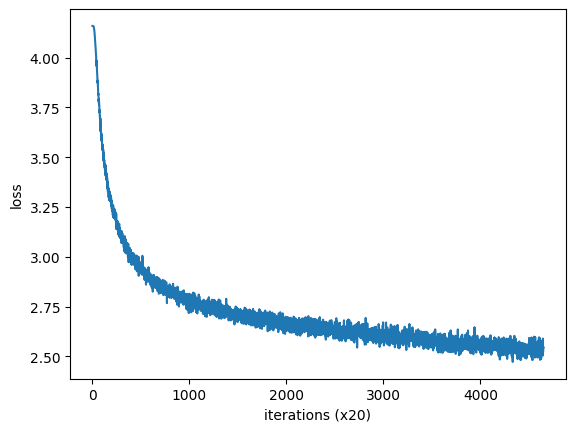

In [11]:
import numpy as np
import pickle
from trainer import Trainer
from optimizer import Adam
from utils import create_contexts_target, to_cpu, to_gpu
from data import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

GPU = False

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

---
---
# GPU에서 CUPY로 학습하기

In [ ]:
!nvidia-smi

Sat Jan 10 02:54:45 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
pip install cupy-cuda12x

In [ ]:
from layers import Embedding
from negative_samplig_layer import NegativeSamplingLoss
from np import *

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------



| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 0[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 0[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 1[s] | 손실 4.04
| 에폭 1 |  반복 101 / 9295 | 시간 1[s] | 손실 3.92
| 에폭 1 |  반복 121 / 9295 | 시간 1[s] | 손실 3.77
| 에폭 1 |  반복 141 / 9295 | 시간 1[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 1[s] | 손실 3.48
| 에폭 1 |  반복 181 / 9295 | 시간 2[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 2[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 2[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 2[s] | 손실 3.10
| 에폭 1 |  반복 261 / 9295 | 시간 2[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 3[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 3[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 3[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 3[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 4[s] | 손실 2.81
| 에폭 1 |  반복 381 / 9295 | 시간 4[s] | 손실 2.79
| 에폭 1 |  반복 401 / 9295 | 시간 4[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 5[s] | 손실 2.77
| 에폭 1 |  반복 441 / 9295 | 시간 5[s] | 손실

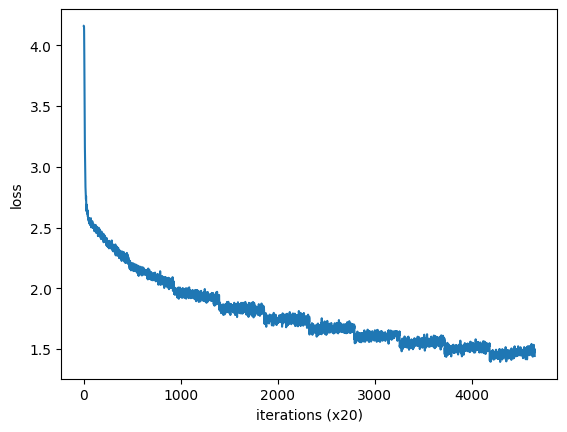

In [ ]:
import numpy
from np import *
import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from trainer import Trainer
from optimizer import Adam
from utils import create_contexts_target, to_cpu, to_gpu
from data import ptb

# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

GPU = True

contexts, target = create_contexts_target(corpus, window_size)
if GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(numpy.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [ ]:
# numpy version 1.x용 pickle 파일 저장

import numpy as np
import pickle

with open("cbow_params.pkl", "rb") as f:
    params = pickle.load(f)

# 완전히 numpy 1.x 친화적으로 재저장
word_vecs = np.asarray(params["word_vecs"], dtype=np.float16)

params = {
    "word_vecs": word_vecs,
    "word_to_id": params["word_to_id"],
    "id_to_word": params["id_to_word"],
}

with open("cbow_params_numpy1.pkl", "wb") as f:
    pickle.dump(params, f, protocol=4)

4.3.3 CBOW 모델 평가

In [1]:
from utils import most_similar
import numpy as np
import pickle
import numpy

pkl_file = 'cbow_params.pkl'

if numpy.__version__[0] == '2':
    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
        word_vecs = params['word_vecs']
        word_to_id = params['word_to_id']
        id_to_word = params['id_to_word']

elif numpy.__version__[0] == '1':
    pkl_file = 'cbow_params_numpy1.pkl'

    with open(pkl_file, 'rb') as f:
        params = pickle.load(f)
        word_vecs = params['word_vecs']
        word_to_id = params['word_to_id']
        id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.720703125
 i: 0.72021484375
 your: 0.66064453125
 they: 0.60302734375
 anybody: 0.58935546875

[query] year
 month: 0.857421875
 week: 0.77099609375
 summer: 0.75048828125
 spring: 0.73046875
 decade: 0.685546875

[query] car
 luxury: 0.6162109375
 cars: 0.61572265625
 truck: 0.58837890625
 window: 0.58203125
 auto: 0.56103515625

[query] toyota
 honda: 0.62451171875
 minivans: 0.61669921875
 engines: 0.61083984375
 mazda: 0.607421875
 marathon: 0.607421875


In [2]:
from utils import analogy
analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:king = woman:?
 horse: 3.9453125
 artist: 3.80859375
 kid: 3.798828125
 globe: 3.69140625
 university: 3.591796875


In [7]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs, top=5)
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top=5)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs, top=5)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 woman: 5.50390625
 a.m: 5.3359375
 lady: 4.7421875
 amendment: 4.6953125
 thing: 4.671875

[analogy] take:took = go:?
 're: 4.67578125
 came: 4.5
 were: 4.35546875
 hour: 4.15234375
 are: 4.109375

[analogy] car:cars = child:?
 a.m: 6.859375
 rape: 5.6015625
 daffynition: 5.140625
 children: 5.03515625
 incest: 4.83203125

[analogy] good:better = bad:?
 rather: 5.88671875
 more: 5.60546875
 less: 5.50390625
 greater: 3.85546875
 worse: 3.57421875


In [ ]:
analogy('man', 'father', 'woman', word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:father = woman:?
 a.m: 6.0546875
 daughter: 5.75390625
 kid: 5.66796875
 wife: 5.24609375
 recital: 4.921875


In [ ]:
analogy('mother', 'daughter', 'father', word_to_id, id_to_word, word_vecs, top=5)


[analogy] mother:daughter = father:?
 actor: 5.078125
 guy: 4.81640625
 comment: 4.8125
 successor: 4.640625
 cubans: 4.58984375
